https://medium.com/mlearning-ai/a-stochastic-model-for-demand-forecating-in-python-a1b568b80b94
  
https://mlpills.dev/time-series/forecasting-in-time-series/

In [1]:
!pip install neuralforecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

import warnings
warnings.filterwarnings('ignore')

### Functions

In [3]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries,color='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False) 
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### Read in the data

In [4]:
data = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=['Month'])
data = data.rename(columns ={'#Passengers':'no_passengers'})
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


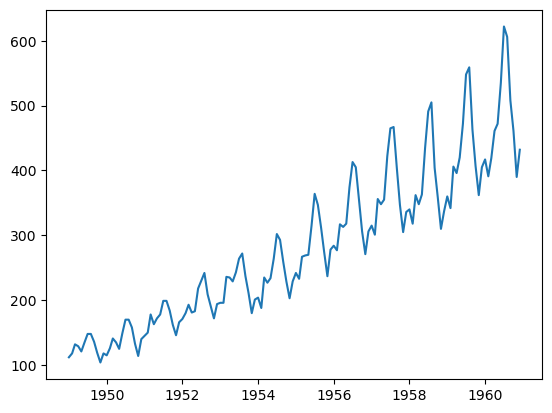

In [5]:
plt.plot(data)
plt.show()

Usually we divide data in train and test set for training the model on train data and testing our model on test data. Here we want to apply monte carlo simulation so we need some data to derive the distribution of random numbers.  
  
Lets divide our data into three parts:  
  
* Train data  
* Data for distribution fitting for MCS  
* Test data  

In [6]:
data_for_dist_fitting = data[-70:]
data_train = data[~data.isin(data_for_dist_fitting).all(1)]
data_test = data_for_dist_fitting[-20:]

data_for_dist_fitting = data_for_dist_fitting[~data_for_dist_fitting.isin(data_test).all(1)]

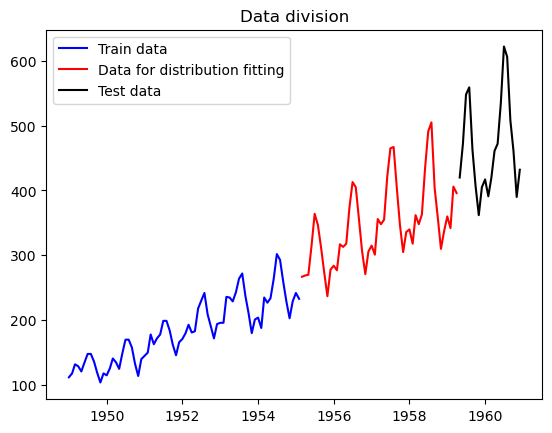

In [7]:
train = plt.plot(data_train,color='blue', label = 'Train data')
data_f_mc = plt.plot(data_for_dist_fitting, color ='red', label ='Data for distribution fitting')
test = plt.plot(data_test, color ='black', label = 'Test data')
plt.legend(loc='best') 
plt.title('Data division')
plt.show(block=False)

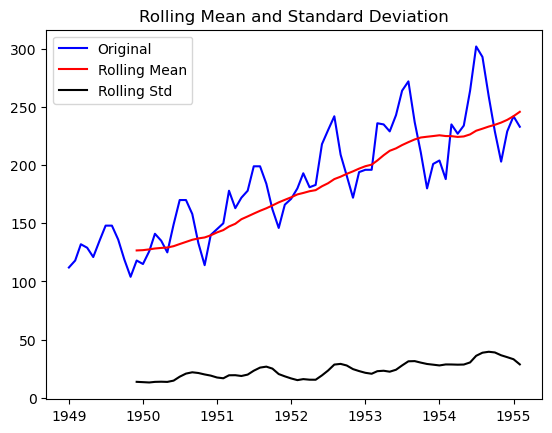

Results of Dickey Fuller Test:
Test Statistic                 -0.076786
p-value                         0.951702
#Lags Used                     12.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [13]:
test_stationarity(data_train)

From the above plot of rolling mean and standart deviation we can say that our time series is not stationary. We have increasing rolling mean which shows that we have positive trend and fluctuating rolling standard deviation shows that we have seasonality in our time series. Also from the results of dickey fuller test- the p-value is 0.951 so we accept the null hypothesis of non stationarity.

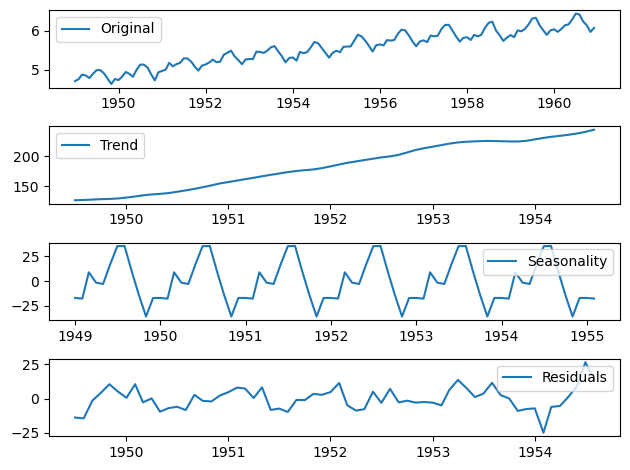

In [18]:
decomposition = seasonal_decompose(data_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
ts_log = np.log(data)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

As we have seasonality in our time series we will use SARIMA model.  
  
SARIMA stands for Seasonal Auto Regressive Integrated Moving Average. It is an extension of ARIMA model. SARIMA model also consider the seasonal component of time series.  
  
Autoregression: It is similar to regular regression. In autoregression it uses observations from previous time steps as input to a regression equation to predict the value at the next time step.  
  
Integrated: This step differencing is done for making the time series more stationary.  
  
Moving Average: Moving average is calculated to reduce the error.  
  
There are three trend elements:  
  
* p: Trend autoregression order. It is the number of lag observations included in the model.  
* d: Trend difference order. The number of times that the raw observations are differenced.  
* q: Trend moving average order. Specifies the size of the moving average window.  
  
Seasonal Elements  
  
* P: Seasonal autoregressive order.  
* D: Seasonal difference order.  
* Q: Seasonal moving average order.  
* m: The number of time steps for a single seasonal period.  

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_train,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as E: 
            print(E)
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58245D+00    |proj g|=  4.64156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   8.015D-06   6.582D+00
  F =   6.5824328610621903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:976.2000634372041
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04383D+00    |proj g|=  8.27152D-01

At iterate    5    f=  2.86851D+00    |proj g|=  1.28519D-02

At iterate   10    f=  2.85464D+00    |proj g|=  2.41972D-01

At iterate   15    f=  2.81108D+00    |proj g|=  3.95176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.012D-05   2.811D+00
  F =   2.8110687671145191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  5.92393D+00    |proj g|=  4.13006D-01

At iterate   20    f=  5.86940D+00    |proj g|=  1.05130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     34      1     0     0   5.620D-06   5.869D+00
  F =   5.8693847061311111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.6689365074044
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30407D+00    |proj g|=  5.49016D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52127D+00    |proj g|=  3.15182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   3.783D-07   3.520D+00
  F =   3.5199517428295914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:524.9528579387795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99913D+00    |proj g|=  4.32568D-01

At iterate    5    f=  2.88151D+00    |proj g|=  1.22232D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.17479D+00    |proj g|=  6.80228D-03
  ys=-6.938E-01  -gs= 6.844E-01 BFGS update SKIPPED

At iterate   10    f=  3.82419D+00    |proj g|=  5.26959D+00

At iterate   15    f=  3.59865D+00    |proj g|=  2.59426D-01

At iterate   20    f=  3.50690D+00    |proj g|=  4.97352D-01

At iterate   25    f=  3.45536D+00    |proj g|=  7.07347D-02

At iterate   30    f=  3.43335D+00    |proj g|=  1.69367D-01

At iterate   35    f=  3.41806D+00    |proj g|=  6.99546D-02

At iterate   40    f=  3.41083D+00    |proj g|=  1.88147D-01

At iterate   45    f=  3.40701D+00    |proj g|=  1.73564D-01

At iterate   50    f=  3.40398D+00    |proj g|=  3.12611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.


  ys=-6.243E-01  -gs= 6.524E-01 BFGS update SKIPPED

At iterate   20    f=  3.59377D+00    |proj g|=  2.71756D-01

At iterate   25    f=  3.10098D+00    |proj g|=  1.64531D+00

At iterate   30    f=  3.03604D+00    |proj g|=  7.79078D-02

At iterate   35    f=  3.03601D+00    |proj g|=  2.13497D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     67      1     1     0   1.962D-04   3.036D+00
  F =   3.0360106536403313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:457.32957673876905
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.90231D+00    |proj g|=  1.31298D-01

At iterate   15    f=  2.89577D+00    |proj g|=  2.92790D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   3.114D-06   2.896D+00
  F =   2.8957690578057416     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:434.57382055524977
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95421D+00    |proj g|=  2.28594D-01

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:363.62879797827554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09838D+00    |proj g|=  1.12432D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      9      1     0     0   1.086D-05   3.098D+00
  F =   3.0983819257100311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:462.5605250050846
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.42827D+00    |proj g|=  9.13612D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.867D-07   2.428D+00
  F =   2.4281972425910467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:365.37319190347495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17448D+00    |proj g|=  4.25175D-02

At iterate    5    f=  4.17321D+00    |proj g|=  6.57725D-03

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   5.732D-07   2.986D+00
  F =   2.9862793460828514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:445.969343220262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36280D+00    |proj g|=  8.64981D-02

At iterate    5    f=  2.35368D+00    |proj g|=  6.17464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24484D+00    |proj g|=  1.92221D-01

At iterate    5    f=  3.14703D+00    |proj g|=  6.99489D-02

At iterate   10    f=  2.87106D+00    |proj g|=  2.02797D-01

At iterate   15    f=  2.85984D+00    |proj g|=  1.54124D-02

At iterate   20    f=  2.85965D+00    |proj g|=  1.05970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.060D-04   2.860D+00
  F =   2.8596473535838904     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.369D-06   2.439D+00
  F =   2.4389741879623563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:366.9681798184287
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36193D+00    |proj g|=  1.24353D-01

At iterate    5    f=  2.34296D+00    |proj g|=  2.03180D-02

At iterate   10    f=  2.34007D+00    |proj g|=  6.87830D-05

           * 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   4.929D-04   4.304D+00
  F =   4.3035399580620739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:640.9239137931869
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53076D+00    |proj g|=  2.64426D-01

At iterate    5    f=  3.48984D+00    |proj g|=  1.50019D-02

At iterate   10    f=  3.48545D+00    |proj g|=  3.97082D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.26163D+00    |proj g|=  4.63480D-01

At iterate   10    f=  3.18898D+00    |proj g|=  6.77584D-01

At iterate   15    f=  2.96447D+00    |proj g|=  7.33008D-01

At iterate   20    f=  2.93390D+00    |proj g|=  2.10445D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     39      1     0     0   4.257D-05   2.934D+00
  F =   2.9338910206141420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:442.215871050893
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.46982D+00    |proj g|=  1.44847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.274D-07   2.470D+00
  F =   2.4698246598515174     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:371.53404965802457
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55696D+00    |proj g|=  1.59267D-01

At iterate    5    f=  2.49923D+00    |proj g|=  2.74031D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   2.589D-06   3.394D+00
  F =   3.3942295364069284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:510.3459713882254
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02837D+00    |proj g|=  8.37851D-03

At iterate    5    f=  3.02825D+00    |proj g|=  4.37459D-03

At iterate   10    f=  3.02800D+00    |proj g|=  1.64423D-04

           * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.40691D+00    |proj g|=  1.73749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   1.737D-05   2.407D+00
  F =   2.4069063667496868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:364.22214227895364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33316D+00    |proj g|=  1.76371D-01

At iterate    5    f=  3.28392D+00    |proj g|=  1.53320D-01

At iterate  

 This problem is unconstrained.



At iterate   10    f=  3.15940D+00    |proj g|=  2.65358D-01

At iterate   15    f=  2.90155D+00    |proj g|=  3.27758D-01

At iterate   20    f=  2.87616D+00    |proj g|=  8.15637D-02

At iterate   25    f=  2.87452D+00    |proj g|=  1.13905D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   1.163D-05   2.874D+00
  F =   2.8744472032542210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:435.4181860816247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.44843D+00    |proj g|=  2.54836D-01

At iterate   10    f=  2.44180D+00    |proj g|=  9.44433D-03

At iterate   15    f=  2.43867D+00    |proj g|=  6.13244D-02

At iterate   20    f=  2.43775D+00    |proj g|=  6.48283D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   9.692D-06   2.438D+00
  F =   2.4377524144601068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:368.7873573400958
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61770D+00    |proj g|=  6.64846D-01

At iterate    5    f=  3.42003D+00    |proj g|=  1.36482D-02

At iterate   10    f=  3.39347D+00    |proj g|=  2.07221D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   8.317D-06   3.393D+00
  F =   3.3934671133570267     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:508.23313277683997
RUNNING THE L

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.90197D+00    |proj g|=  1.12967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   1.130D-05   2.902D+00
  F =   2.9019656288921207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:437.49091307603385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39599D+00    |proj g|=  6.38696D-02

At iterate    5    f=  2.39067D+00    |proj g|=  1.54438D-02

           *

 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:361.75396910135834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17645D+00    |proj g|=  3.61467D-02

At iterate    5    f=  4.16291D+00    |proj g|=  2.38754D-02

At iterate   10    f=  4.16240D+00    |proj g|=  1.28666D-02

At iterate   15    f=  4.16164D+00    |proj g|=  5.91441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   1.017D-06   4.162D+00
  F =   4.1616383130412578     

CONVERGENCE:

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   4.568D-05   3.319D+00
  F =   3.3194894409452482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:499.2844372598967
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97330D+00    |proj g|=  1.58622D-02

At iterate    5    f=  2.97283D+00    |proj g|=  3.84982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   9.690D-06   2.344D+00
  F =   2.3437190543917770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:354.870420049983
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27419D+00    |proj g|=  1.24323D-01

At iterate    5    f=  3.20954D+00    |proj g|=  2.11803D-01

At iterate   10    f=  3.02441D+00    |proj g|=  5.50427D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.16969D+00    |proj g|=  7.18599D-02

At iterate   10    f=  2.90622D+00    |proj g|=  4.29558D-01

At iterate   15    f=  2.85891D+00    |proj g|=  5.47229D-03

At iterate   20    f=  2.85694D+00    |proj g|=  2.73494D-02

At iterate   25    f=  2.85417D+00    |proj g|=  4.35025D-03

At iterate   30    f=  2.85414D+00    |proj g|=  1.08541D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     41      1     0     0   1.085D-05   2.854D+00
  F =   2.8541429411787775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:432.4131552944

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.32966D+00    |proj g|=  2.38705D-02

At iterate   10    f=  2.32486D+00    |proj g|=  2.06001D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   3.943D-05   2.325D+00
  F =   2.3246609601178849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:354.04982209744696


In [25]:
mod = SARIMAX(data_train,order = (1,1,1),
              seasonal_order = (1, 1, 1, 12),
              enforce_invertibility = False,
              enforce_stationarity = False)
results = mod.fit(disp = 0)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                   74
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -172.025
Date:                            Tue, 14 Nov 2023   AIC                            354.050
Time:                                    10:59:46   BIC                            363.301
Sample:                                01-01-1949   HQIC                           357.531
                                     - 02-01-1955                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8316      0.179     -4.637      0.000      -1.183      -0.480
ma.L1          0.6404      0.223   

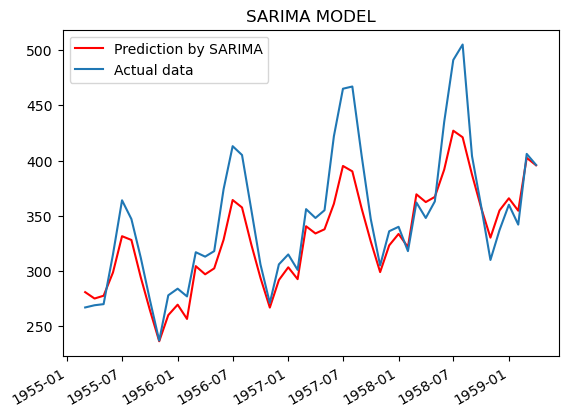

In [28]:
pred_sarima = results.forecast(50)
fig, ax = plt.subplots()
predicted = plt.plot(pred_sarima, label = 'Prediction by SARIMA', color='red')
Actual = plt.plot(data_for_dist_fitting, label = 'Actual data')
plt.legend(loc = 'best') 
plt.title('SARIMA MODEL')
fig.autofmt_xdate()
plt.show(block = False)

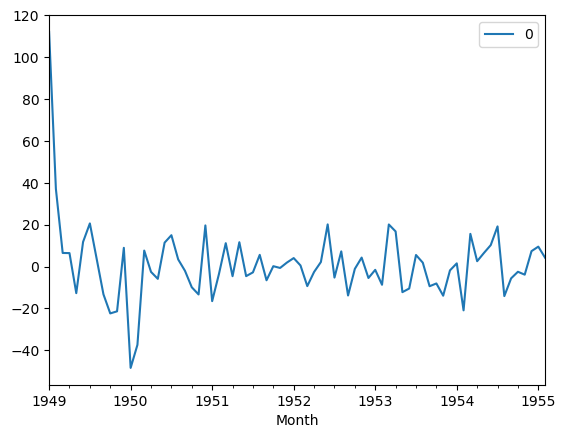

In [29]:
residual_error = pd.DataFrame(results.resid)
residual_error.plot()
plt.show()

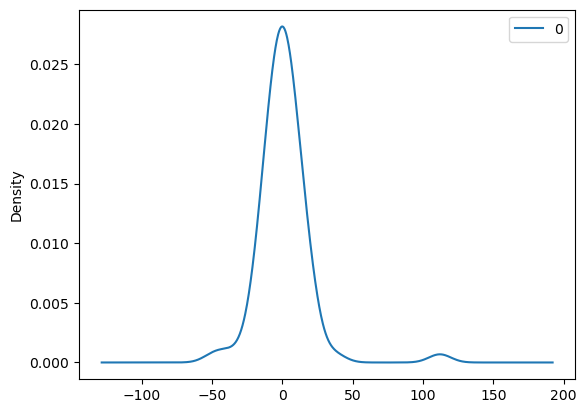

   count      mean        std        min       25%      50%       75%    max
0   74.0  0.993986  18.611649 -48.409166 -7.703533 -0.26391  7.314967  112.0


In [30]:
residual_error.plot(kind='kde')
plt.show()
print(residual_error.describe().T)

Test MSE: 123.982


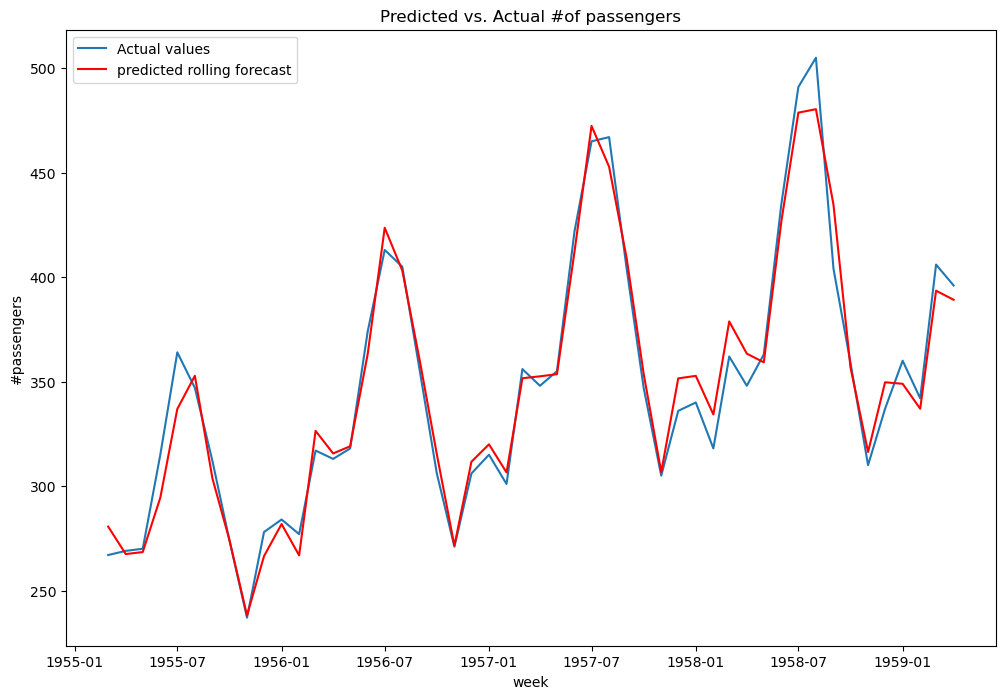

In [32]:
### creating new dataframe for rolling forescast ç

history = np.log(data_train.astype(float))
predictions = list()
for i in range(len(data_for_dist_fitting)): 
    model = SARIMAX(history,
                    order = (1,1,1),
                    seasonal_order = (1, 1, 1, 12),
                    enforce_invertibility = False,
                    enforce_stationarity = False)
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()                         ### generate forcecast for next period ###    
    yhat = np.e ** output[0]                              ### Save the prediction value in yhat ###    
    predictions.append(yhat)                              ### Append yhat to the list of prediction ###    
    obs = data_for_dist_fitting[i : i + 1]                ### grabs the observation at the ith index ###    
    history = history.append(np.log(obs.astype(float)))   ### appends the observation to the estimation data set ###
    
### prints the MSE of the model for the rolling forecast period ###
error = mean_squared_error(data_for_dist_fitting, predictions)
print('Test MSE: %.3f' % error)

predictions = pd.DataFrame(predictions)
predictions.index = data_for_dist_fitting.index

mlp.rcParams['figure.figsize'] = (12,8)

plt.plot(data_for_dist_fitting, label = 'Actual values')
plt.plot(predictions, color = 'red', label = 'predicted rolling forecast')
plt.legend(loc = 'best')
plt.xlabel('week')
plt.ylabel('#passengers')
plt.title('Predicted vs. Actual #of passengers')
plt.show()

count    50.000000
mean     -0.297832
std      11.243760
min     -30.567931
25%      -6.633230
50%      -0.760183
75%       7.920493
max      27.089195
dtype: float64


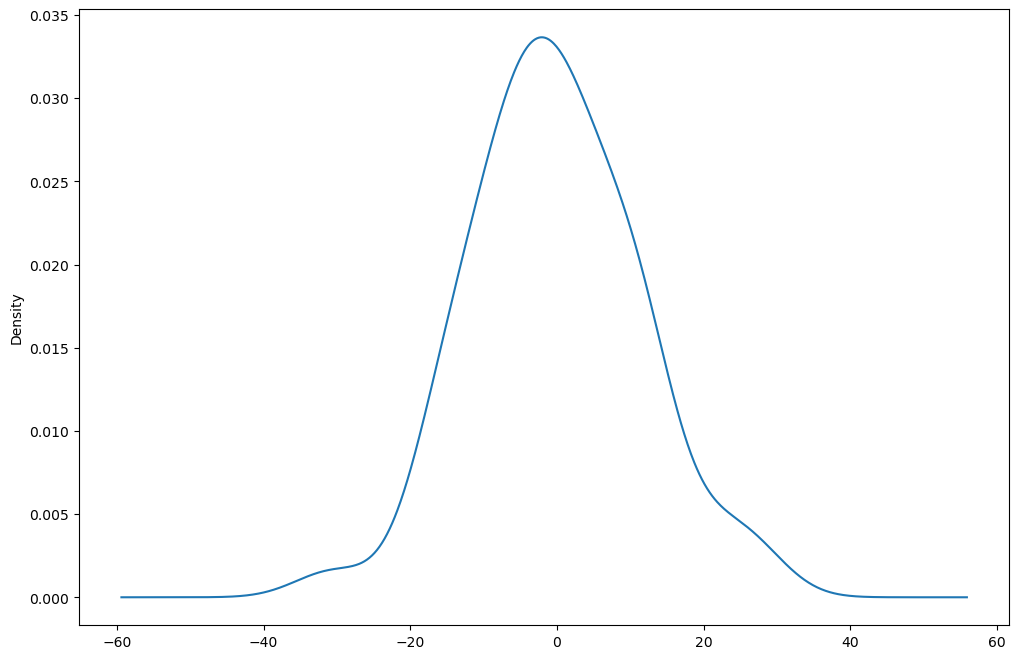

In [37]:
mlp.rcParams['figure.figsize'] = (12,8)
 
rf_errors = data_for_dist_fitting.Passengers - predictions[0]
rf_errors.plot(kind = 'kde')

print(rf_errors.astype(float).describe().T)

### Neural Forecast

https://nixtla.mintlify.app/neuralforecast/index.html

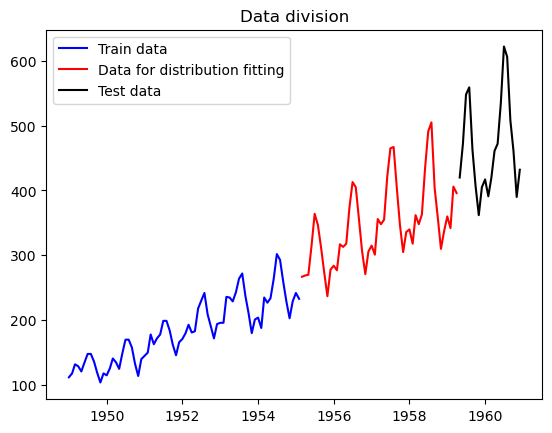

In [9]:
train = plt.plot(data_train,color='blue', label = 'Train data')
data_f_mc = plt.plot(data_for_dist_fitting, color ='red', label ='Data for distribution fitting')
test = plt.plot(data_test, color ='black', label = 'Test data')
plt.legend(loc='best') 
plt.title('Data division')
plt.show(block=False)

In [26]:
data = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=['Month'])
data = data.reset_index()
data = data.rename(columns ={'#Passengers':'no_passengers', 'Month':'ds'})
data.index = data.ds

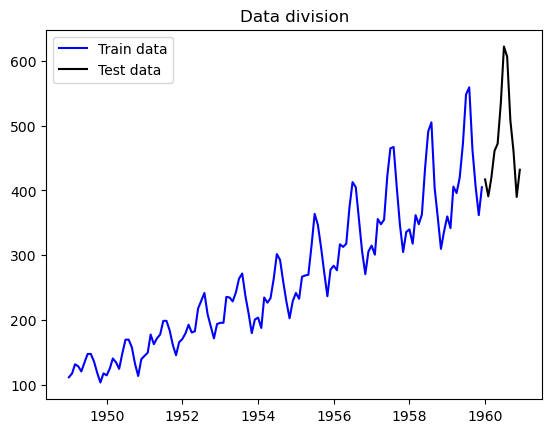

In [27]:
Y_train_df = data[data.ds <= '1959-12-31'] # 132 train
Y_test_df = data[data.ds > '1959-12-31'] # 12 test

train = plt.plot(Y_train_df.Passengers,color='blue', label = 'Train data')
test = plt.plot(Y_test_df.Passengers, color ='black', label = 'Test data')
plt.legend(loc='best') 
plt.title('Data division')
plt.show(block=False)

In [1]:
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h = horizon, max_steps = 50),
          NHITS(input_size=2 * horizon, h = horizon, max_steps = 50)]
nf = NeuralForecast(models = models, freq = 'M')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

NameError: name 'Y_test_df' is not defined